In [2]:
import os
import re
import unicodedata
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import requests
from bs4 import BeautifulSoup 
from lxml import html
from tqdm import tqdm
import glob
from sec_edgar_downloader import Downloader
from inscriptis import get_text
import urllib.request
import copy

In [ ]:
#Get SP500 constituent companies' stock tickers
sp500_tickers = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv").iloc[:,0].to_list()

In [ ]:
#Identify stock tickers that include periods
for i in sp500_tickers:
    if '.' in i:
        print(i)

In [ ]:
#Replace tickers with periods with CIK numbers
sp500_tickers.remove('BRK.B')
sp500_tickers.remove('BF.B')
sp500_tickers.append('0001067983')
sp500_tickers.append('0000014693')

In [ ]:
#Create directory and subdirectories for files
os.mkdir('HTMfiles')
for ticker in sp500_tickers:
    os.mkdir('HTMfiles/'+ticker)

In [ ]:
#Get the links for the 10-K index pages for each company
hrefs = {}
for ticker in sp500_tickers:
    stringindices = []
    rss = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=' + str(ticker) +'&type=10-k%25&dateb=&owner=exclude&start=0&count=40&output=atom'
    page = requests.get(rss)
    indices = BeautifulSoup(page.content, 'html.parser').find_all('filing-href')
    for i in indices:
        stringindices.append(str(i)[13:-14])
    hrefs.update({ticker:stringindices})

In [ ]:
#Get links for the htm-formatted 10-K reports for each company
links = {}
for href in tqdm(hrefs):
    report_links = []
    for i in hrefs[href]:
        page = requests.get(i)
        link = 'https://www.sec.gov/' + str(BeautifulSoup(page.content, 'html.parser').find_all('a')[9]).split('"')[1]
        report_links.append(link)
        links.update({href:report_links})
        

In [ ]:
links_copy = copy.copy(links)

In [ ]:
tickers = list(links_copy.keys())

In [ ]:
#Remove links to exhibits, addenda etc.
for ticker in links:
    for i in links[ticker]:
        if i[-3:] != 'htm':
            links[ticker].remove(i)
exhibits = []
for ticker in links_copy:
    for i in links_copy[ticker]:
        if 'ex' in i:
            exhibits.append(i)
for ticker in links_copy:
    for i in links_copy[ticker]:
        if i in exhibits:
            links_copy[ticker].remove(i)
unfinished = []
for ticker in links:
    for i in links[ticker]:
        if (i[-1] == '/'):
            unfinished.append(i)
for ticker in links_copy:
    for i in links_copy[ticker]:
        if i in unfinished:
            links_copy[ticker].remove(i)

In [ ]:
#Remove tickers with fewer than 2 reports
for ticker in links_copy:
    if len(links_copy[ticker])<2:
        del links_copy[ticker]


In [ ]:
#Remove duplicate entries for Google
del links_copy['GOOGL']

In [ ]:
#Save links_copy to csv
(pd.DataFrame.from_dict(links_copy, orient='index')).to_csv('links_dict.csv')

In [24]:
#Define function to normalize text, put text in lower case, remove numbers
#and special characters, and remove breaks and extra spaces
def Clean(text):
    text = unicodedata.normalize('NFKD', text)
    text = text.lower()
    text = re.sub('[^a-z]+', ' ', text)
    text = " ".join(text.split())
    return text

In [ ]:
#Create cleaned local text files from 10-K links
problems = []
for ticker in tqdm(links_copy):
    try:
        for i in range(len(links_copy[ticker])):
            html = urllib.request.urlopen(links_copy[ticker][i]).read().decode('utf-8')
            text = get_text(html)
            text = Clean(text)
            f = open('HTMfiles/' +ticker +'/'+str(i), 'w')
            f.write(text)
            f.close()
    except:
        problems.append(ticker)

In [ ]:
#Create list of text files' file paths, sort by ticker and number
filepaths = []
for ticker in tqdm(tickers):
    for i in (glob.glob('HTMfiles/'+ticker+'/*')):
        filepaths.append(i)
filepaths.sort()

In [ ]:
#Split file paths into ticker and number 
years = []
for filepath in filepaths:
    years.append(filepath.split('/'))
#Identify consecutive 10-k reports
pairs = []    
for i in range(len(years)-1):
    if (years[i][0] == years[i+1][0]):
        pairs.append([years[i],years[i+1]])
#Rejoin file paths
joinedpairs = []
for i in range(len(pairs)):    
    duos.append([pairs[i][0][0]+'/'+pairs[i][0][1], pairs[i][1][0]+'/'+pairs[i][1][1]])

In [278]:
pairs

[[['0000014693', '0'], ['0000014693', '1']],
 [['0000014693', '1'], ['0000014693', '2']],
 [['0000014693', '2'], ['0000014693', '3']],
 [['0000014693', '3'], ['0000014693', '4']],
 [['0000014693', '4'], ['0000014693', '5']],
 [['0000014693', '5'], ['0000014693', '6']],
 [['0000014693', '6'], ['0000014693', '7']],
 [['0000014693', '7'], ['0000014693', '8']],
 [['0001067983', '0'], ['0001067983', '1']],
 [['0001067983', '1'], ['0001067983', '2']],
 [['0001067983', '2'], ['0001067983', '3']],
 [['0001067983', '3'], ['0001067983', '4']],
 [['0001067983', '4'], ['0001067983', '5']],
 [['0001067983', '5'], ['0001067983', '6']],
 [['0001067983', '6'], ['0001067983', '7']],
 [['0001067983', '7'], ['0001067983', '8']],
 [['0001067983', '8'], ['0001067983', '9']],
 [['A', '0'], ['A', '1']],
 [['A', '1'], ['A', '2']],
 [['A', '2'], ['A', '3']],
 [['A', '3'], ['A', '4']],
 [['A', '4'], ['A', '5']],
 [['A', '5'], ['A', '6']],
 [['A', '6'], ['A', '7']],
 [['A', '7'], ['A', '8']],
 [['A', '8'], ['A',

In [ ]:
def ComputeJaccardSimilarity(words_A, words_B):
    # Count number of words in both A and B
    words_intersect = len(words_A.intersection(words_B))
    
    # Count number of words in A or B
    words_union = len(words_A.union(words_B))
    
    # Compute Jaccard similarity score
    jaccard_score = words_intersect / words_union
    
    return jaccard_score

In [ ]:
#Obtain Jaccard Similarity Scores for consecutive 10-k reports
jaccard_scores = []
error = []
for i in tqdm(joinedpairs):
    text1 = str(pd.read_csv(i[0]))[26:-11]
    text2 = str(pd.read_csv(i[1]))[26:-11]
    words1 = set(text1.split())
    words2 = set(text2.split())
    jaccard_score = ComputeJaccardSimilarity(words1,words2)
    jaccard_scores.append(jaccard_score)


 31%|███       | 150/491 [50:59<2:10:18, 22.93s/it]


 60%|█████▉    | 294/491 [1:42:19<55:10, 16.81s/it]


 90%|████████▉ | 441/491 [2:38:14<15:08, 18.16s/it]


100%|██████████| 491/491 [2:57:07<00:00, 19.86s/it]

In [43]:
counts = {}
for ticker in links_copy:
    for i in glob.glob(ticker+'/*'):
        count.append(i)
    counts.update({ticker:len(count)})
for ticker in counts:
    if counts[ticker]==0:
        print(ticker)

In [44]:
counts

{'MMM': 10,
 'AOS': 9,
 'ABT': 10,
 'ABBV': 6,
 'ACN': 9,
 'ATVI': 11,
 'AYI': 8,
 'ADBE': 10,
 'AAP': 9,
 'AMD': 9,
 'AES': 10,
 'AET': 9,
 'AMG': 9,
 'AFL': 10,
 'A': 10,
 'APD': 10,
 'AKAM': 10,
 'ALK': 9,
 'ALB': 9,
 'ARE': 9,
 'ALXN': 10,
 'ALGN': 9,
 'ALLE': 5,
 'AGN': 6,
 'ADS': 9,
 'LNT': 9,
 'ALL': 10,
 'GOOG': 4,
 'MO': 10,
 'AMZN': 10,
 'AEE': 10,
 'AAL': 10,
 'AEP': 12,
 'AXP': 10,
 'AIG': 10,
 'AMT': 10,
 'AWK': 9,
 'AMP': 10,
 'ABC': 10,
 'AME': 10,
 'AMGN': 10,
 'APH': 10,
 'APC': 11,
 'ADI': 10,
 'ANDV': 8,
 'ANSS': 9,
 'ANTM': 10,
 'AON': 10,
 'APA': 11,
 'AIV': 9,
 'AAPL': 11,
 'AMAT': 11,
 'APTV': 7,
 'ADM': 14,
 'ARNC': 11,
 'AJG': 9,
 'AIZ': 11,
 'T': 10,
 'ADSK': 10,
 'ADP': 9,
 'AZO': 12,
 'AVB': 10,
 'AVY': 9,
 'BHGE': 2,
 'BLL': 9,
 'BAC': 10,
 'BAX': 10,
 'BBT': 10,
 'BDX': 11,
 'BBY': 10,
 'BIIB': 10,
 'BLK': 10,
 'HRB': 10,
 'BA': 10,
 'BKNG': 10,
 'BWA': 11,
 'BXP': 10,
 'BSX': 10,
 'BHF': 2,
 'BMY': 10,
 'CHRW': 10,
 'CA': 9,
 'COG': 11,
 'CDNS': 9,
 'CPB'

In [74]:
tickers = list(links_copy.keys())

In [80]:
for filepath in filepaths:

In [257]:
filepaths

[['MMM/9',
  'MMM/0',
  'MMM/7',
  'MMM/6',
  'MMM/1',
  'MMM/8',
  'MMM/4',
  'MMM/3',
  'MMM/2',
  'MMM/5'],
 ['AOS/0',
  'AOS/7',
  'AOS/6',
  'AOS/1',
  'AOS/8',
  'AOS/4',
  'AOS/3',
  'AOS/2',
  'AOS/5'],
 ['ABT/9',
  'ABT/0',
  'ABT/7',
  'ABT/6',
  'ABT/1',
  'ABT/8',
  'ABT/4',
  'ABT/3',
  'ABT/2',
  'ABT/5'],
 ['ABBV/0', 'ABBV/1', 'ABBV/4', 'ABBV/3', 'ABBV/2', 'ABBV/5'],
 ['ACN/0',
  'ACN/7',
  'ACN/6',
  'ACN/1',
  'ACN/8',
  'ACN/4',
  'ACN/3',
  'ACN/2',
  'ACN/5'],
 ['ATVI/9',
  'ATVI/0',
  'ATVI/7',
  'ATVI/6',
  'ATVI/1',
  'ATVI/10',
  'ATVI/8',
  'ATVI/4',
  'ATVI/3',
  'ATVI/2',
  'ATVI/5'],
 ['AYI/0', 'AYI/7', 'AYI/6', 'AYI/1', 'AYI/4', 'AYI/3', 'AYI/2', 'AYI/5'],
 ['ADBE/9',
  'ADBE/0',
  'ADBE/7',
  'ADBE/6',
  'ADBE/1',
  'ADBE/8',
  'ADBE/4',
  'ADBE/3',
  'ADBE/2',
  'ADBE/5'],
 ['AAP/0',
  'AAP/7',
  'AAP/6',
  'AAP/1',
  'AAP/8',
  'AAP/4',
  'AAP/3',
  'AAP/2',
  'AAP/5'],
 ['AMD/0',
  'AMD/7',
  'AMD/6',
  'AMD/1',
  'AMD/8',
  'AMD/4',
  'AMD/3',
  'AMD/2



  0%|          | 0/491 [00:00<?, ?it/s]

 40%|████      | 197/491 [00:00<00:00, 1968.88it/s]

 80%|████████  | 395/491 [00:00<00:00, 1961.72it/s]

100%|██████████| 491/491 [00:00<00:00, 1916.97it/s]

In [189]:
for i in joinedpairs[:5]:
    print(i[0])

0000014693/0
0000014693/1
0000014693/2
0000014693/3
0000014693/4




  0%|          | 0/4159 [00:00<?, ?it/s]

  0%|          | 2/4159 [00:00<05:47, 11.95it/s]

  0%|          | 4/4159 [00:00<05:40, 12.21it/s]

  0%|          | 6/4159 [00:00<05:23, 12.82it/s]

  0%|          | 8/4159 [00:00<04:57, 13.96it/s]

  0%|          | 10/4159 [00:00<05:48, 11.89it/s]

  0%|          | 12/4159 [00:01<06:33, 10.54it/s]

  0%|          | 13/4159 [00:01<07:15,  9.52it/s]

  0%|          | 14/4159 [00:01<07:41,  8.98it/s]

  0%|          | 15/4159 [00:01<08:01,  8.61it/s]

  0%|          | 16/4159 [00:01<08:08,  8.48it/s]

  0%|          | 17/4159 [00:01<08:09,  8.45it/s]

  0%|          | 18/4159 [00:01<08:20,  8.27it/s]

  0%|          | 19/4159 [00:01<08:36,  8.02it/s]

  0%|          | 20/4159 [00:02<08:40,  7.96it/s]

  1%|          | 21/4159 [00:02<08:38,  7.98it/s]

  1%|          | 22/4159 [00:02<08:43,  7.90it/s]

  1%|          | 23/4159 [00:02<09:19,  7.40it/s]

  1%|          | 24/4159 [00:02<09:53,  6.97it/s]

  1%|          | 25/4159 [00:02<09:31,  7.

  5%|▌         | 214/4159 [00:25<09:41,  6.78it/s]

  5%|▌         | 215/4159 [00:26<09:51,  6.66it/s]

  5%|▌         | 216/4159 [00:26<10:25,  6.30it/s]

  5%|▌         | 217/4159 [00:26<10:35,  6.20it/s]

  5%|▌         | 218/4159 [00:26<10:27,  6.28it/s]

  5%|▌         | 219/4159 [00:26<09:54,  6.63it/s]

  5%|▌         | 220/4159 [00:26<09:21,  7.01it/s]

  5%|▌         | 221/4159 [00:26<08:53,  7.38it/s]

  5%|▌         | 222/4159 [00:27<08:36,  7.62it/s]

  5%|▌         | 223/4159 [00:27<08:17,  7.91it/s]

  5%|▌         | 224/4159 [00:27<07:53,  8.30it/s]

  5%|▌         | 225/4159 [00:27<07:34,  8.65it/s]

  5%|▌         | 227/4159 [00:27<07:15,  9.03it/s]

  6%|▌         | 229/4159 [00:27<06:45,  9.70it/s]

  6%|▌         | 231/4159 [00:27<06:23, 10.25it/s]

  6%|▌         | 233/4159 [00:28<06:18, 10.39it/s]

  6%|▌         | 235/4159 [00:28<06:12, 10.55it/s]

  6%|▌         | 237/4159 [00:28<06:49,  9.59it/s]

  6%|▌         | 238/4159 [00:28<07:23,  8.84it/s]

  6%|▌      

 10%|▉         | 409/4159 [00:48<07:36,  8.21it/s]

 10%|▉         | 410/4159 [00:49<08:01,  7.78it/s]

 10%|▉         | 411/4159 [00:49<08:22,  7.46it/s]

 10%|▉         | 412/4159 [00:49<09:10,  6.80it/s]

 10%|▉         | 413/4159 [00:49<09:05,  6.87it/s]

 10%|▉         | 415/4159 [00:49<08:01,  7.78it/s]

 10%|█         | 416/4159 [00:49<08:06,  7.69it/s]

 10%|█         | 417/4159 [00:49<07:59,  7.81it/s]

 10%|█         | 418/4159 [00:50<07:47,  8.01it/s]

 10%|█         | 419/4159 [00:50<07:28,  8.33it/s]

 10%|█         | 420/4159 [00:50<07:12,  8.65it/s]

 10%|█         | 422/4159 [00:50<06:51,  9.09it/s]

 10%|█         | 423/4159 [00:50<06:43,  9.26it/s]

 10%|█         | 425/4159 [00:50<06:14,  9.97it/s]

 10%|█         | 427/4159 [00:50<05:43, 10.85it/s]

 10%|█         | 429/4159 [00:51<05:22, 11.55it/s]

 10%|█         | 431/4159 [00:51<05:03, 12.29it/s]

 10%|█         | 433/4159 [00:51<06:31,  9.51it/s]

 10%|█         | 435/4159 [00:51<07:15,  8.55it/s]

 10%|█      

 14%|█▍        | 596/4159 [01:12<06:51,  8.66it/s]

 14%|█▍        | 599/4159 [01:12<05:24, 10.96it/s]

 14%|█▍        | 601/4159 [01:12<04:50, 12.27it/s]

 14%|█▍        | 603/4159 [01:13<05:43, 10.37it/s]

 15%|█▍        | 605/4159 [01:13<06:18,  9.39it/s]

 15%|█▍        | 607/4159 [01:13<06:44,  8.78it/s]

 15%|█▍        | 609/4159 [01:14<06:57,  8.50it/s]

 15%|█▍        | 611/4159 [01:14<07:10,  8.24it/s]

 15%|█▍        | 612/4159 [01:14<07:15,  8.15it/s]

 15%|█▍        | 613/4159 [01:14<07:22,  8.02it/s]

 15%|█▍        | 614/4159 [01:14<07:28,  7.90it/s]

 15%|█▍        | 615/4159 [01:14<07:34,  7.80it/s]

 15%|█▍        | 616/4159 [01:14<07:46,  7.59it/s]

 15%|█▍        | 617/4159 [01:15<07:59,  7.39it/s]

 15%|█▍        | 618/4159 [01:15<09:00,  6.55it/s]

 15%|█▍        | 619/4159 [01:15<09:32,  6.18it/s]

 15%|█▍        | 620/4159 [01:15<08:39,  6.81it/s]

 15%|█▍        | 621/4159 [01:15<07:58,  7.40it/s]

 15%|█▍        | 622/4159 [01:15<07:26,  7.91it/s]

 15%|█▌     

 19%|█▉        | 795/4159 [01:36<06:46,  8.27it/s]

 19%|█▉        | 796/4159 [01:36<06:53,  8.14it/s]

 19%|█▉        | 797/4159 [01:36<06:59,  8.02it/s]

 19%|█▉        | 798/4159 [01:36<07:08,  7.85it/s]

 19%|█▉        | 800/4159 [01:36<06:32,  8.56it/s]

 19%|█▉        | 801/4159 [01:36<07:33,  7.40it/s]

 19%|█▉        | 802/4159 [01:37<08:54,  6.28it/s]

 19%|█▉        | 803/4159 [01:37<10:03,  5.56it/s]

 19%|█▉        | 804/4159 [01:37<08:46,  6.37it/s]

 19%|█▉        | 806/4159 [01:37<07:44,  7.22it/s]

 19%|█▉        | 808/4159 [01:37<07:00,  7.97it/s]

 19%|█▉        | 809/4159 [01:37<06:37,  8.42it/s]

 19%|█▉        | 811/4159 [01:38<06:09,  9.05it/s]

 20%|█▉        | 813/4159 [01:38<05:26, 10.26it/s]

 20%|█▉        | 815/4159 [01:38<04:52, 11.44it/s]

 20%|█▉        | 817/4159 [01:38<04:23, 12.70it/s]

 20%|█▉        | 819/4159 [01:38<03:56, 14.14it/s]

 20%|█▉        | 821/4159 [01:38<04:43, 11.76it/s]

 20%|█▉        | 823/4159 [01:39<05:56,  9.36it/s]

 20%|█▉     

 24%|██▎       | 981/4159 [01:58<04:36, 11.48it/s]

 24%|██▎       | 983/4159 [01:59<05:03, 10.48it/s]

 24%|██▎       | 985/4159 [01:59<05:18,  9.96it/s]

 24%|██▎       | 987/4159 [01:59<05:17,  9.98it/s]

 24%|██▍       | 989/4159 [01:59<05:08, 10.28it/s]

 24%|██▍       | 991/4159 [01:59<05:19,  9.91it/s]

 24%|██▍       | 993/4159 [02:00<05:49,  9.07it/s]

 24%|██▍       | 994/4159 [02:00<06:11,  8.52it/s]

 24%|██▍       | 995/4159 [02:00<06:32,  8.07it/s]

 24%|██▍       | 996/4159 [02:00<06:39,  7.92it/s]

 24%|██▍       | 997/4159 [02:00<06:43,  7.84it/s]

 24%|██▍       | 999/4159 [02:00<06:26,  8.18it/s]

 24%|██▍       | 1001/4159 [02:01<05:58,  8.80it/s]

 24%|██▍       | 1003/4159 [02:01<05:31,  9.51it/s]

 24%|██▍       | 1005/4159 [02:01<05:08, 10.22it/s]

 24%|██▍       | 1007/4159 [02:01<04:52, 10.76it/s]

 24%|██▍       | 1009/4159 [02:01<04:40, 11.22it/s]

 24%|██▍       | 1011/4159 [02:01<04:30, 11.62it/s]

 24%|██▍       | 1013/4159 [02:01<04:07, 12.72it/s]

 24%|

 28%|██▊       | 1174/4159 [02:21<08:21,  5.95it/s]

 28%|██▊       | 1175/4159 [02:21<08:11,  6.08it/s]

 28%|██▊       | 1176/4159 [02:21<08:03,  6.17it/s]

 28%|██▊       | 1178/4159 [02:21<06:57,  7.14it/s]

 28%|██▊       | 1180/4159 [02:22<06:07,  8.11it/s]

 28%|██▊       | 1182/4159 [02:22<05:26,  9.13it/s]

 28%|██▊       | 1184/4159 [02:22<04:48, 10.30it/s]

 29%|██▊       | 1187/4159 [02:22<03:58, 12.48it/s]

 29%|██▊       | 1189/4159 [02:22<04:00, 12.33it/s]

 29%|██▊       | 1191/4159 [02:22<04:11, 11.78it/s]

 29%|██▊       | 1193/4159 [02:23<04:19, 11.41it/s]

 29%|██▊       | 1195/4159 [02:23<04:21, 11.34it/s]

 29%|██▉       | 1197/4159 [02:23<04:24, 11.18it/s]

 29%|██▉       | 1199/4159 [02:23<04:38, 10.64it/s]

 29%|██▉       | 1201/4159 [02:23<04:44, 10.40it/s]

 29%|██▉       | 1203/4159 [02:23<04:49, 10.20it/s]

 29%|██▉       | 1205/4159 [02:24<04:29, 10.95it/s]

 29%|██▉       | 1207/4159 [02:24<04:25, 11.13it/s]

 29%|██▉       | 1210/4159 [02:24<03:49, 12.86

 33%|███▎      | 1369/4159 [02:45<07:04,  6.57it/s]

 33%|███▎      | 1370/4159 [02:45<07:35,  6.12it/s]

 33%|███▎      | 1371/4159 [02:45<08:22,  5.55it/s]

 33%|███▎      | 1372/4159 [02:45<08:51,  5.24it/s]

 33%|███▎      | 1373/4159 [02:46<09:08,  5.08it/s]

 33%|███▎      | 1374/4159 [02:46<09:21,  4.96it/s]

 33%|███▎      | 1375/4159 [02:46<09:36,  4.83it/s]

 33%|███▎      | 1376/4159 [02:46<08:19,  5.57it/s]

 33%|███▎      | 1378/4159 [02:46<07:12,  6.43it/s]

 33%|███▎      | 1379/4159 [02:47<06:34,  7.04it/s]

 33%|███▎      | 1380/4159 [02:47<06:14,  7.42it/s]

 33%|███▎      | 1381/4159 [02:47<06:04,  7.62it/s]

 33%|███▎      | 1382/4159 [02:47<05:44,  8.06it/s]

 33%|███▎      | 1383/4159 [02:47<05:26,  8.51it/s]

 33%|███▎      | 1384/4159 [02:47<05:13,  8.86it/s]

 33%|███▎      | 1386/4159 [02:47<04:56,  9.36it/s]

 33%|███▎      | 1388/4159 [02:47<04:41,  9.85it/s]

 33%|███▎      | 1391/4159 [02:48<04:07, 11.20it/s]

 33%|███▎      | 1393/4159 [02:48<04:41,  9.81

 38%|███▊      | 1584/4159 [03:13<05:34,  7.70it/s]

 38%|███▊      | 1585/4159 [03:13<05:37,  7.63it/s]

 38%|███▊      | 1586/4159 [03:13<05:33,  7.72it/s]

 38%|███▊      | 1587/4159 [03:13<06:05,  7.04it/s]

 38%|███▊      | 1588/4159 [03:13<06:01,  7.10it/s]

 38%|███▊      | 1589/4159 [03:13<05:56,  7.20it/s]

 38%|███▊      | 1590/4159 [03:13<05:29,  7.80it/s]

 38%|███▊      | 1591/4159 [03:13<05:08,  8.32it/s]

 38%|███▊      | 1593/4159 [03:14<04:46,  8.95it/s]

 38%|███▊      | 1595/4159 [03:14<04:34,  9.35it/s]

 38%|███▊      | 1596/4159 [03:14<04:31,  9.43it/s]

 38%|███▊      | 1598/4159 [03:14<04:16,  9.99it/s]

 38%|███▊      | 1600/4159 [03:14<04:03, 10.52it/s]

 39%|███▊      | 1602/4159 [03:14<03:54, 10.90it/s]

 39%|███▊      | 1604/4159 [03:15<03:53, 10.95it/s]

 39%|███▊      | 1606/4159 [03:15<03:54, 10.87it/s]

 39%|███▊      | 1608/4159 [03:15<03:45, 11.30it/s]

 39%|███▊      | 1610/4159 [03:15<03:39, 11.62it/s]

 39%|███▉      | 1612/4159 [03:15<03:30, 12.11

 43%|████▎     | 1782/4159 [03:34<03:07, 12.66it/s]

 43%|████▎     | 1784/4159 [03:34<02:50, 13.93it/s]

 43%|████▎     | 1786/4159 [03:34<02:53, 13.68it/s]

 43%|████▎     | 1788/4159 [03:34<03:06, 12.69it/s]

 43%|████▎     | 1790/4159 [03:34<03:15, 12.12it/s]

 43%|████▎     | 1792/4159 [03:35<03:22, 11.71it/s]

 43%|████▎     | 1794/4159 [03:35<03:22, 11.71it/s]

 43%|████▎     | 1796/4159 [03:35<04:11,  9.40it/s]

 43%|████▎     | 1798/4159 [03:36<05:30,  7.15it/s]

 43%|████▎     | 1799/4159 [03:36<06:34,  5.98it/s]

 43%|████▎     | 1800/4159 [03:36<07:21,  5.34it/s]

 43%|████▎     | 1801/4159 [03:36<07:55,  4.96it/s]

 43%|████▎     | 1802/4159 [03:36<07:03,  5.57it/s]

 43%|████▎     | 1803/4159 [03:37<06:33,  5.99it/s]

 43%|████▎     | 1804/4159 [03:37<05:58,  6.57it/s]

 43%|████▎     | 1805/4159 [03:37<05:29,  7.14it/s]

 43%|████▎     | 1806/4159 [03:37<05:14,  7.49it/s]

 43%|████▎     | 1807/4159 [03:37<05:01,  7.81it/s]

 43%|████▎     | 1808/4159 [03:37<04:54,  7.97

 48%|████▊     | 1994/4159 [03:56<04:27,  8.08it/s]

 48%|████▊     | 1996/4159 [03:57<04:03,  8.87it/s]

 48%|████▊     | 1997/4159 [03:57<03:59,  9.01it/s]

 48%|████▊     | 1998/4159 [03:57<03:56,  9.12it/s]

 48%|████▊     | 2000/4159 [03:57<03:39,  9.84it/s]

 48%|████▊     | 2002/4159 [03:57<03:32, 10.14it/s]

 48%|████▊     | 2004/4159 [03:57<03:12, 11.17it/s]

 48%|████▊     | 2006/4159 [03:58<03:06, 11.53it/s]

 48%|████▊     | 2008/4159 [03:58<03:02, 11.77it/s]

 48%|████▊     | 2010/4159 [03:58<03:23, 10.55it/s]

 48%|████▊     | 2012/4159 [03:58<03:38,  9.84it/s]

 48%|████▊     | 2014/4159 [03:58<03:47,  9.43it/s]

 48%|████▊     | 2015/4159 [03:58<03:56,  9.07it/s]

 48%|████▊     | 2016/4159 [03:59<04:07,  8.66it/s]

 48%|████▊     | 2017/4159 [03:59<04:11,  8.53it/s]

 49%|████▊     | 2018/4159 [03:59<04:05,  8.73it/s]

 49%|████▊     | 2019/4159 [03:59<04:02,  8.84it/s]

 49%|████▊     | 2020/4159 [03:59<03:58,  8.99it/s]

 49%|████▊     | 2021/4159 [03:59<03:59,  8.91

 53%|█████▎    | 2208/4159 [04:21<03:39,  8.89it/s]

 53%|█████▎    | 2210/4159 [04:21<03:09, 10.30it/s]

 53%|█████▎    | 2212/4159 [04:21<02:46, 11.67it/s]

 53%|█████▎    | 2214/4159 [04:21<02:43, 11.87it/s]

 53%|█████▎    | 2217/4159 [04:21<02:21, 13.68it/s]

 53%|█████▎    | 2220/4159 [04:21<02:05, 15.51it/s]

 53%|█████▎    | 2223/4159 [04:22<01:54, 16.95it/s]

 53%|█████▎    | 2225/4159 [04:22<02:01, 15.87it/s]

 54%|█████▎    | 2227/4159 [04:22<02:14, 14.42it/s]

 54%|█████▎    | 2229/4159 [04:22<02:27, 13.11it/s]

 54%|█████▎    | 2231/4159 [04:22<02:42, 11.87it/s]

 54%|█████▎    | 2233/4159 [04:23<02:55, 10.96it/s]

 54%|█████▎    | 2235/4159 [04:23<03:27,  9.29it/s]

 54%|█████▍    | 2237/4159 [04:23<03:50,  8.34it/s]

 54%|█████▍    | 2238/4159 [04:23<04:07,  7.77it/s]

 54%|█████▍    | 2239/4159 [04:23<04:20,  7.38it/s]

 54%|█████▍    | 2240/4159 [04:24<04:28,  7.15it/s]

 54%|█████▍    | 2241/4159 [04:24<04:34,  7.00it/s]

 54%|█████▍    | 2242/4159 [04:24<04:49,  6.62

 58%|█████▊    | 2423/4159 [04:43<02:33, 11.31it/s]

 58%|█████▊    | 2425/4159 [04:43<02:36, 11.09it/s]

 58%|█████▊    | 2427/4159 [04:43<02:35, 11.11it/s]

 58%|█████▊    | 2429/4159 [04:44<02:39, 10.86it/s]

 58%|█████▊    | 2432/4159 [04:44<02:10, 13.22it/s]

 59%|█████▊    | 2434/4159 [04:44<02:07, 13.52it/s]

 59%|█████▊    | 2436/4159 [04:44<02:00, 14.32it/s]

 59%|█████▊    | 2438/4159 [04:44<01:58, 14.56it/s]

 59%|█████▊    | 2440/4159 [04:44<02:05, 13.65it/s]

 59%|█████▊    | 2442/4159 [04:44<02:21, 12.12it/s]

 59%|█████▉    | 2444/4159 [04:45<02:29, 11.50it/s]

 59%|█████▉    | 2446/4159 [04:45<02:30, 11.38it/s]

 59%|█████▉    | 2448/4159 [04:45<02:32, 11.21it/s]

 59%|█████▉    | 2450/4159 [04:45<02:51,  9.95it/s]

 59%|█████▉    | 2452/4159 [04:46<02:59,  9.53it/s]

 59%|█████▉    | 2453/4159 [04:46<03:02,  9.35it/s]

 59%|█████▉    | 2454/4159 [04:46<03:05,  9.20it/s]

 59%|█████▉    | 2455/4159 [04:46<03:09,  9.01it/s]

 59%|█████▉    | 2456/4159 [04:46<03:07,  9.10

 63%|██████▎   | 2615/4159 [05:06<04:00,  6.43it/s]

 63%|██████▎   | 2617/4159 [05:06<03:26,  7.48it/s]

 63%|██████▎   | 2619/4159 [05:06<03:01,  8.50it/s]

 63%|██████▎   | 2621/4159 [05:06<02:58,  8.61it/s]

 63%|██████▎   | 2622/4159 [05:07<02:55,  8.77it/s]

 63%|██████▎   | 2623/4159 [05:07<02:52,  8.92it/s]

 63%|██████▎   | 2624/4159 [05:07<02:50,  9.00it/s]

 63%|██████▎   | 2625/4159 [05:07<02:50,  9.02it/s]

 63%|██████▎   | 2626/4159 [05:07<02:51,  8.92it/s]

 63%|██████▎   | 2627/4159 [05:07<03:00,  8.51it/s]

 63%|██████▎   | 2628/4159 [05:07<03:12,  7.95it/s]

 63%|██████▎   | 2629/4159 [05:07<03:26,  7.41it/s]

 63%|██████▎   | 2630/4159 [05:08<03:36,  7.05it/s]

 63%|██████▎   | 2631/4159 [05:08<03:42,  6.87it/s]

 63%|██████▎   | 2632/4159 [05:08<03:46,  6.73it/s]

 63%|██████▎   | 2633/4159 [05:08<03:50,  6.62it/s]

 63%|██████▎   | 2634/4159 [05:08<04:00,  6.33it/s]

 63%|██████▎   | 2635/4159 [05:08<04:01,  6.32it/s]

 63%|██████▎   | 2636/4159 [05:09<04:00,  6.32

 68%|██████▊   | 2814/4159 [05:28<01:09, 19.23it/s]

 68%|██████▊   | 2819/4159 [05:28<00:57, 23.46it/s]

 68%|██████▊   | 2823/4159 [05:28<01:17, 17.24it/s]

 68%|██████▊   | 2826/4159 [05:29<01:42, 13.01it/s]

 68%|██████▊   | 2828/4159 [05:29<01:58, 11.19it/s]

 68%|██████▊   | 2830/4159 [05:29<02:13,  9.95it/s]

 68%|██████▊   | 2832/4159 [05:29<02:16,  9.73it/s]

 68%|██████▊   | 2834/4159 [05:29<02:16,  9.68it/s]

 68%|██████▊   | 2836/4159 [05:30<02:28,  8.92it/s]

 68%|██████▊   | 2838/4159 [05:30<02:37,  8.38it/s]

 68%|██████▊   | 2839/4159 [05:30<02:50,  7.73it/s]

 68%|██████▊   | 2840/4159 [05:30<02:51,  7.69it/s]

 68%|██████▊   | 2841/4159 [05:30<02:53,  7.58it/s]

 68%|██████▊   | 2842/4159 [05:31<02:57,  7.40it/s]

 68%|██████▊   | 2843/4159 [05:31<02:56,  7.47it/s]

 68%|██████▊   | 2844/4159 [05:31<02:51,  7.68it/s]

 68%|██████▊   | 2845/4159 [05:31<02:44,  7.98it/s]

 68%|██████▊   | 2846/4159 [05:31<02:39,  8.24it/s]

 68%|██████▊   | 2847/4159 [05:31<02:39,  8.24

 73%|███████▎  | 3044/4159 [05:53<03:18,  5.63it/s]

 73%|███████▎  | 3046/4159 [05:53<02:51,  6.51it/s]

 73%|███████▎  | 3047/4159 [05:53<02:35,  7.17it/s]

 73%|███████▎  | 3048/4159 [05:53<02:25,  7.64it/s]

 73%|███████▎  | 3050/4159 [05:54<02:02,  9.04it/s]

 73%|███████▎  | 3052/4159 [05:54<01:51,  9.94it/s]

 73%|███████▎  | 3054/4159 [05:54<02:04,  8.87it/s]

 73%|███████▎  | 3056/4159 [05:54<02:13,  8.27it/s]

 74%|███████▎  | 3057/4159 [05:54<02:15,  8.16it/s]

 74%|███████▎  | 3058/4159 [05:55<02:16,  8.04it/s]

 74%|███████▎  | 3059/4159 [05:55<02:20,  7.85it/s]

 74%|███████▎  | 3061/4159 [05:55<02:10,  8.40it/s]

 74%|███████▎  | 3063/4159 [05:55<02:00,  9.06it/s]

 74%|███████▎  | 3065/4159 [05:55<01:55,  9.47it/s]

 74%|███████▎  | 3066/4159 [05:55<01:54,  9.55it/s]

 74%|███████▎  | 3067/4159 [05:55<01:53,  9.64it/s]

 74%|███████▍  | 3068/4159 [05:56<01:52,  9.69it/s]

 74%|███████▍  | 3069/4159 [05:56<01:52,  9.70it/s]

 74%|███████▍  | 3070/4159 [05:56<02:31,  7.17

 77%|███████▋  | 3204/4159 [06:17<02:10,  7.32it/s]

 77%|███████▋  | 3206/4159 [06:17<01:46,  8.97it/s]

 77%|███████▋  | 3208/4159 [06:17<01:29, 10.68it/s]

 77%|███████▋  | 3211/4159 [06:17<01:16, 12.41it/s]

 77%|███████▋  | 3213/4159 [06:17<01:17, 12.26it/s]

 77%|███████▋  | 3215/4159 [06:18<01:25, 11.02it/s]

 77%|███████▋  | 3217/4159 [06:18<01:27, 10.78it/s]

 77%|███████▋  | 3219/4159 [06:18<01:29, 10.46it/s]

 77%|███████▋  | 3221/4159 [06:18<01:55,  8.15it/s]

 77%|███████▋  | 3222/4159 [06:19<02:16,  6.86it/s]

 77%|███████▋  | 3223/4159 [06:19<02:30,  6.23it/s]

 78%|███████▊  | 3224/4159 [06:19<02:39,  5.85it/s]

 78%|███████▊  | 3225/4159 [06:19<02:43,  5.70it/s]

 78%|███████▊  | 3226/4159 [06:19<02:40,  5.80it/s]

 78%|███████▊  | 3227/4159 [06:20<02:35,  5.99it/s]

 78%|███████▊  | 3229/4159 [06:20<02:21,  6.58it/s]

 78%|███████▊  | 3230/4159 [06:20<02:19,  6.68it/s]

 78%|███████▊  | 3231/4159 [06:20<02:11,  7.08it/s]

 78%|███████▊  | 3232/4159 [06:20<02:04,  7.43

 82%|████████▏ | 3431/4159 [06:43<01:09, 10.49it/s]

 83%|████████▎ | 3433/4159 [06:43<01:03, 11.40it/s]

 83%|████████▎ | 3435/4159 [06:43<01:04, 11.16it/s]

 83%|████████▎ | 3437/4159 [06:43<00:57, 12.45it/s]

 83%|████████▎ | 3440/4159 [06:43<00:51, 13.87it/s]

 83%|████████▎ | 3442/4159 [06:44<00:49, 14.57it/s]

 83%|████████▎ | 3444/4159 [06:44<00:58, 12.20it/s]

 83%|████████▎ | 3446/4159 [06:44<00:59, 12.08it/s]

 83%|████████▎ | 3448/4159 [06:44<00:55, 12.87it/s]

 83%|████████▎ | 3450/4159 [06:44<00:52, 13.50it/s]

 83%|████████▎ | 3453/4159 [06:44<00:45, 15.68it/s]

 83%|████████▎ | 3455/4159 [06:45<00:47, 14.82it/s]

 83%|████████▎ | 3457/4159 [06:45<01:12,  9.74it/s]

 83%|████████▎ | 3459/4159 [06:45<01:33,  7.48it/s]

 83%|████████▎ | 3461/4159 [06:46<01:52,  6.20it/s]

 83%|████████▎ | 3462/4159 [06:46<02:05,  5.55it/s]

 83%|████████▎ | 3463/4159 [06:46<02:12,  5.24it/s]

 83%|████████▎ | 3464/4159 [06:46<02:19,  4.98it/s]

 83%|████████▎ | 3465/4159 [06:47<02:30,  4.61

 88%|████████▊ | 3646/4159 [07:06<01:35,  5.35it/s]

 88%|████████▊ | 3647/4159 [07:06<01:45,  4.84it/s]

 88%|████████▊ | 3648/4159 [07:07<01:50,  4.61it/s]

 88%|████████▊ | 3649/4159 [07:07<01:58,  4.31it/s]

 88%|████████▊ | 3650/4159 [07:07<02:00,  4.21it/s]

 88%|████████▊ | 3652/4159 [07:07<01:37,  5.19it/s]

 88%|████████▊ | 3654/4159 [07:08<01:18,  6.40it/s]

 88%|████████▊ | 3656/4159 [07:08<01:05,  7.66it/s]

 88%|████████▊ | 3658/4159 [07:08<00:55,  9.03it/s]

 88%|████████▊ | 3660/4159 [07:08<00:56,  8.85it/s]

 88%|████████▊ | 3662/4159 [07:08<01:06,  7.45it/s]

 88%|████████▊ | 3663/4159 [07:09<01:02,  8.00it/s]

 88%|████████▊ | 3665/4159 [07:09<00:58,  8.39it/s]

 88%|████████▊ | 3666/4159 [07:09<00:58,  8.46it/s]

 88%|████████▊ | 3669/4159 [07:09<00:47, 10.41it/s]

 88%|████████▊ | 3672/4159 [07:09<00:38, 12.69it/s]

 88%|████████▊ | 3676/4159 [07:09<00:33, 14.25it/s]

 88%|████████▊ | 3678/4159 [07:10<00:40, 11.89it/s]

 88%|████████▊ | 3680/4159 [07:10<00:43, 10.94

 93%|█████████▎| 3877/4159 [07:29<00:34,  8.06it/s]

 93%|█████████▎| 3878/4159 [07:29<00:35,  8.03it/s]

 93%|█████████▎| 3880/4159 [07:30<00:31,  8.76it/s]

 93%|█████████▎| 3881/4159 [07:30<00:31,  8.91it/s]

 93%|█████████▎| 3882/4159 [07:30<00:32,  8.46it/s]

 93%|█████████▎| 3883/4159 [07:30<00:37,  7.40it/s]

 93%|█████████▎| 3884/4159 [07:30<00:38,  7.07it/s]

 93%|█████████▎| 3885/4159 [07:30<00:39,  6.95it/s]

 93%|█████████▎| 3886/4159 [07:30<00:39,  6.92it/s]

 93%|█████████▎| 3887/4159 [07:31<00:39,  6.83it/s]

 93%|█████████▎| 3888/4159 [07:31<00:42,  6.43it/s]

 94%|█████████▎| 3889/4159 [07:31<00:40,  6.61it/s]

 94%|█████████▎| 3890/4159 [07:31<00:39,  6.83it/s]

 94%|█████████▎| 3891/4159 [07:31<00:38,  6.95it/s]

 94%|█████████▎| 3892/4159 [07:31<00:36,  7.36it/s]

 94%|█████████▎| 3893/4159 [07:31<00:34,  7.80it/s]

 94%|█████████▎| 3894/4159 [07:32<00:32,  8.19it/s]

 94%|█████████▎| 3895/4159 [07:32<00:31,  8.34it/s]

 94%|█████████▎| 3896/4159 [07:32<00:30,  8.65

 98%|█████████▊| 4072/4159 [07:52<00:09,  9.59it/s]

 98%|█████████▊| 4074/4159 [07:52<00:09,  8.58it/s]

 98%|█████████▊| 4075/4159 [07:52<00:10,  7.78it/s]

 98%|█████████▊| 4076/4159 [07:52<00:11,  7.36it/s]

 98%|█████████▊| 4077/4159 [07:52<00:11,  7.10it/s]

 98%|█████████▊| 4078/4159 [07:53<00:11,  6.78it/s]

 98%|█████████▊| 4079/4159 [07:53<00:13,  5.79it/s]

 98%|█████████▊| 4080/4159 [07:53<00:14,  5.34it/s]

 98%|█████████▊| 4081/4159 [07:53<00:15,  5.09it/s]

 98%|█████████▊| 4082/4159 [07:53<00:15,  5.02it/s]

 98%|█████████▊| 4083/4159 [07:54<00:15,  4.95it/s]

 98%|█████████▊| 4084/4159 [07:54<00:15,  4.87it/s]

 98%|█████████▊| 4085/4159 [07:54<00:13,  5.49it/s]

 98%|█████████▊| 4087/4159 [07:54<00:11,  6.46it/s]

 98%|█████████▊| 4089/4159 [07:54<00:09,  7.56it/s]

 98%|█████████▊| 4091/4159 [07:55<00:08,  8.36it/s]

 98%|█████████▊| 4092/4159 [07:55<00:07,  8.76it/s]

 98%|█████████▊| 4093/4159 [07:55<00:07,  8.74it/s]

 98%|█████████▊| 4094/4159 [07:55<00:07,  8.94

In [ ]:
#Obtain ticker and report number
ticker = []
for pair in pairs:
    ticker.append(pair[0][0])
date = []
for pair in pairs:
    date.append(pair[0][1])

#Create dataframe 
df = pd.DataFrame(list(zip(ticker, date, jaccard_scores)), columns=['Ticker', 'Year','Jaccard'])

#Convert report number to report year
df.Year = df.Year.apply(lambda x: int(x))
number = range(17)
year = range(2003,2020)[::-1]
year_dict = {}
for i in number:
    year_dict.update({number[i]:year[i]})
df.Year = df.Year.map(year_dict)

In [ ]:
def ComputeCosineSimilarity(words1, words2):
# Compile complete set of words in A or B
    
    words = words1.union(words2)
    
    # Determine which words are in A
    vector_A = [1 if x in words1 else 0 for x in words]
    
    # Determine which words are in B
    vector_B = [1 if x in words2 else 0 for x in words]
    
    # Compute cosine score using scikit-learn
    array_A = np.array(vector_A).reshape(1, -1)
    array_B = np.array(vector_B).reshape(1, -1)
    cosine_score = cosine_similarity(array_A, array_B)[0,0]
    
    return cosine_score

In [ ]:
#Obtain cosine scores
cosine_scores = []
for i in tqdm(joinedpairs):    
    text1 = str(pd.read_csv(i[0]))[26:-11]
    text2 = str(pd.read_csv(i[1]))[26:-11]
    words1 = set(text1.split())
    words2 = set(text2.split())
    c = ComputeCosineSimilarity(words1,words2)
    cosine_scores.append(c)
df['Cosine'] = cosine_scores

In [275]:
df.to_csv('finalmod3df.csv')

In [286]:
df.Cosine.median()

0.9401696790484002

In [287]:
df.Jaccard.median()

0.8869589192169838

In [288]:
df['logCos'] = np.log(df.Cosine)

In [290]:
df['logJacc'] = np.log(df.Jaccard)

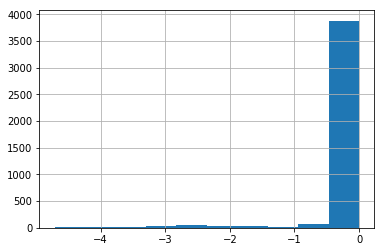

In [291]:
df.logJacc.hist()